In [215]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import FiniteDifference as fd
import LiquidCrystalHelper as lch

from importlib import reload

In [240]:
import ipywidgets as widgets
from IPython.display import display

In [216]:
reload(lch)

<module 'LiquidCrystalHelper' from 'C:\\Users\\lucas\\Documents\\Grad Work\\Summer Research 2020\\LiquidCrystalHelper.py'>

In [217]:
%matplotlib inline
dpi = 700
mpl.rcParams['figure.dpi'] = dpi

# Testing the forward euler test
1. Generate a domain
2. Generate a tactoid on that domain
3. Get $\eta$, $\mu$, and $nu$ values for that configuration.
4. Plot.
5. Step forward once for some small time $\Delta t$ (need to check on exactly how small).
6. Plot again to see if anything is different.
7. If anything has blown up, figure out what -- otherwise just keep stepping to see what happens.

In [218]:
l = 10
n = 300

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

In [219]:
S_val = 1
ctr = [0, 0]
r = 2
m = 1

S, phi = lch.makeTactoid(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)

In [220]:
eta, mu, nu = lch.auxVars(Q)

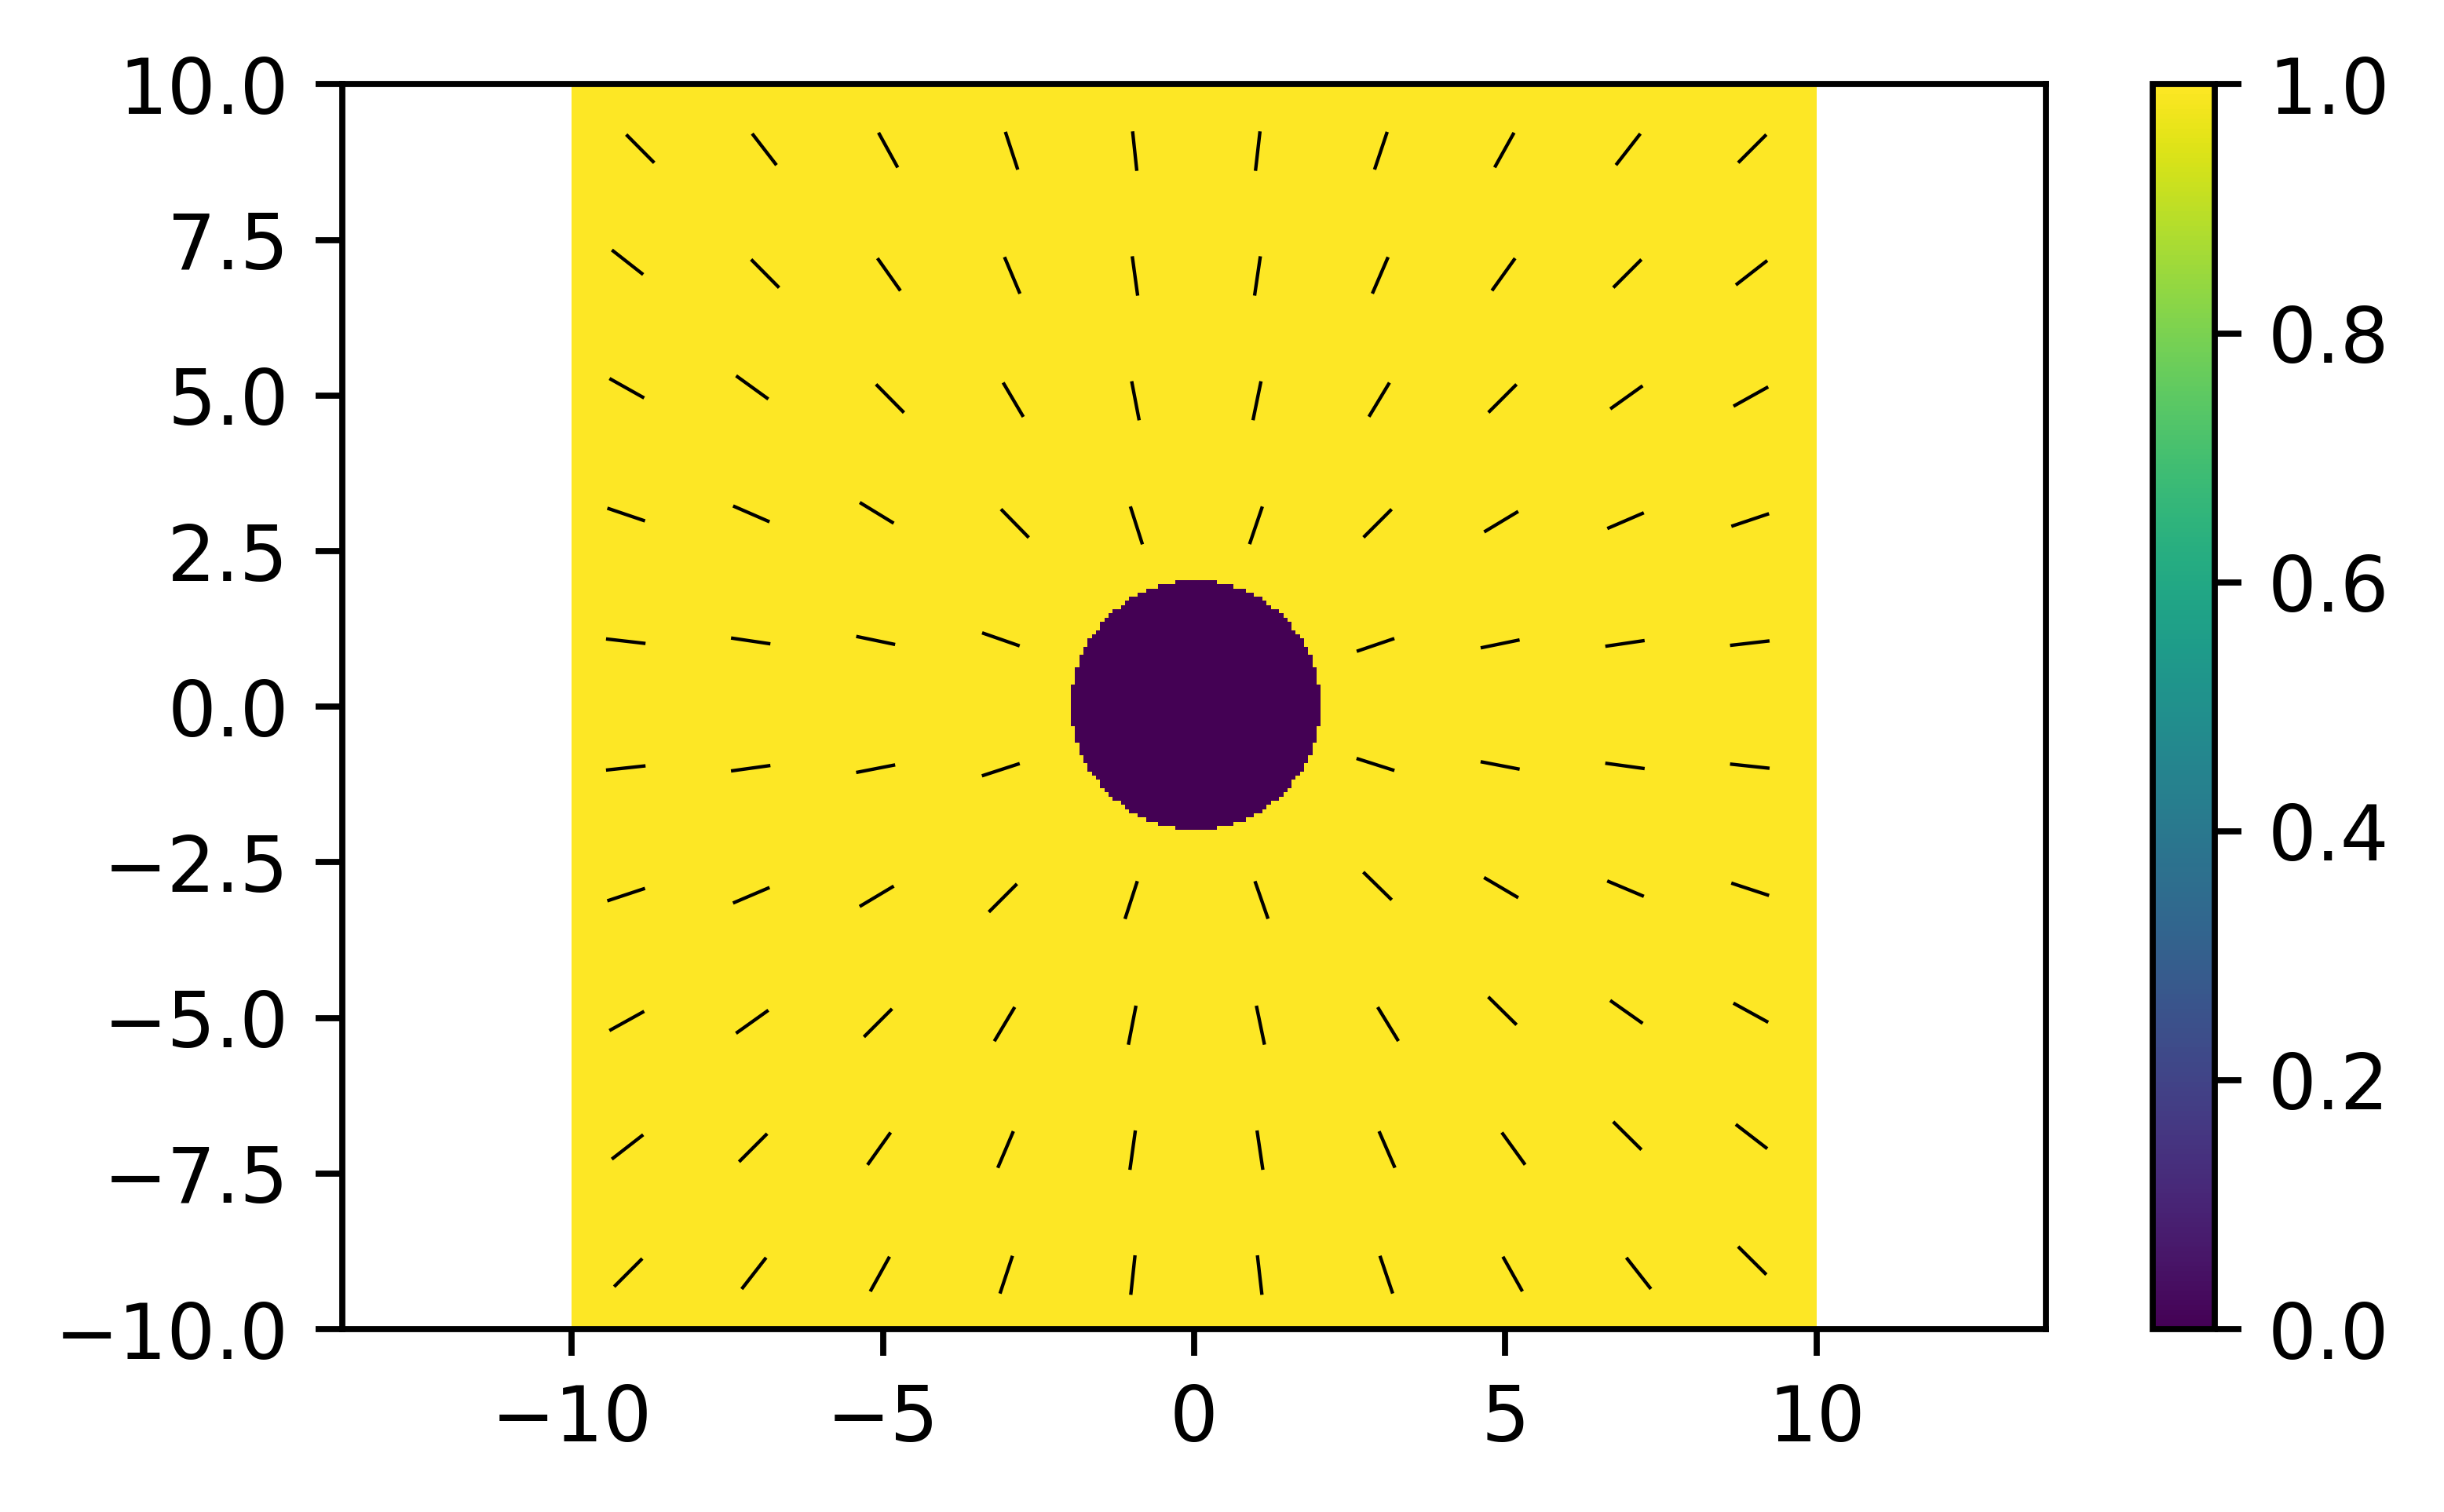

In [221]:
sparse_shape = (10, 10)
S_sparse_shape = (200, 200)
S_cutoff = 0.3

lambda_pm = lch.calcQEigenvals(eta, mu, nu)
U, V = lch.calcQEigenvecs(eta, mu, nu, lambda_pm, S_cutoff)

sparse_idx = lch.sparseIdx(Q[0, 0].shape, sparse_shape)
S_sparse_idx = lch.sparseIdx(Q[0, 0].shape, S_sparse_shape)

fig, ax = plt.subplots(figsize=(5, 3))
c = ax.pcolor(X[S_sparse_idx], Y[S_sparse_idx], S[S_sparse_idx])
q = ax.quiver(X[sparse_idx], Y[sparse_idx], U[sparse_idx], V[sparse_idx],
              headwidth=0, pivot='middle', headaxislength=5, scale=30, width=0.002)
ax.quiverkey(q, X=0.3, Y=1.1, U=10,
             label='Quiver key, length = 10', labelpos='E')
ax.axis('equal')
fig.colorbar(c, ax=ax)

In [249]:
dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

# This is just what they said it should be for stability
dt = dx**2/8

In [250]:
num_steps = 5000

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)

eta_old = eta
mu_old = mu
nu_old = nu

for i in range(num_steps):
    
    eta_new = fd.forwardEuler(eta_old, dt, lch.etaEOM, mu_old, nu_old, dx, dy)
    mu_new = fd.forwardEuler(mu_old, dt, lch.muEOM, eta_old, nu_old, dx, dy)
    nu_new = fd.forwardEuler(nu_old, dt, lch.nuEOM, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    progress.value = i

IntProgress(value=0, max=5000)

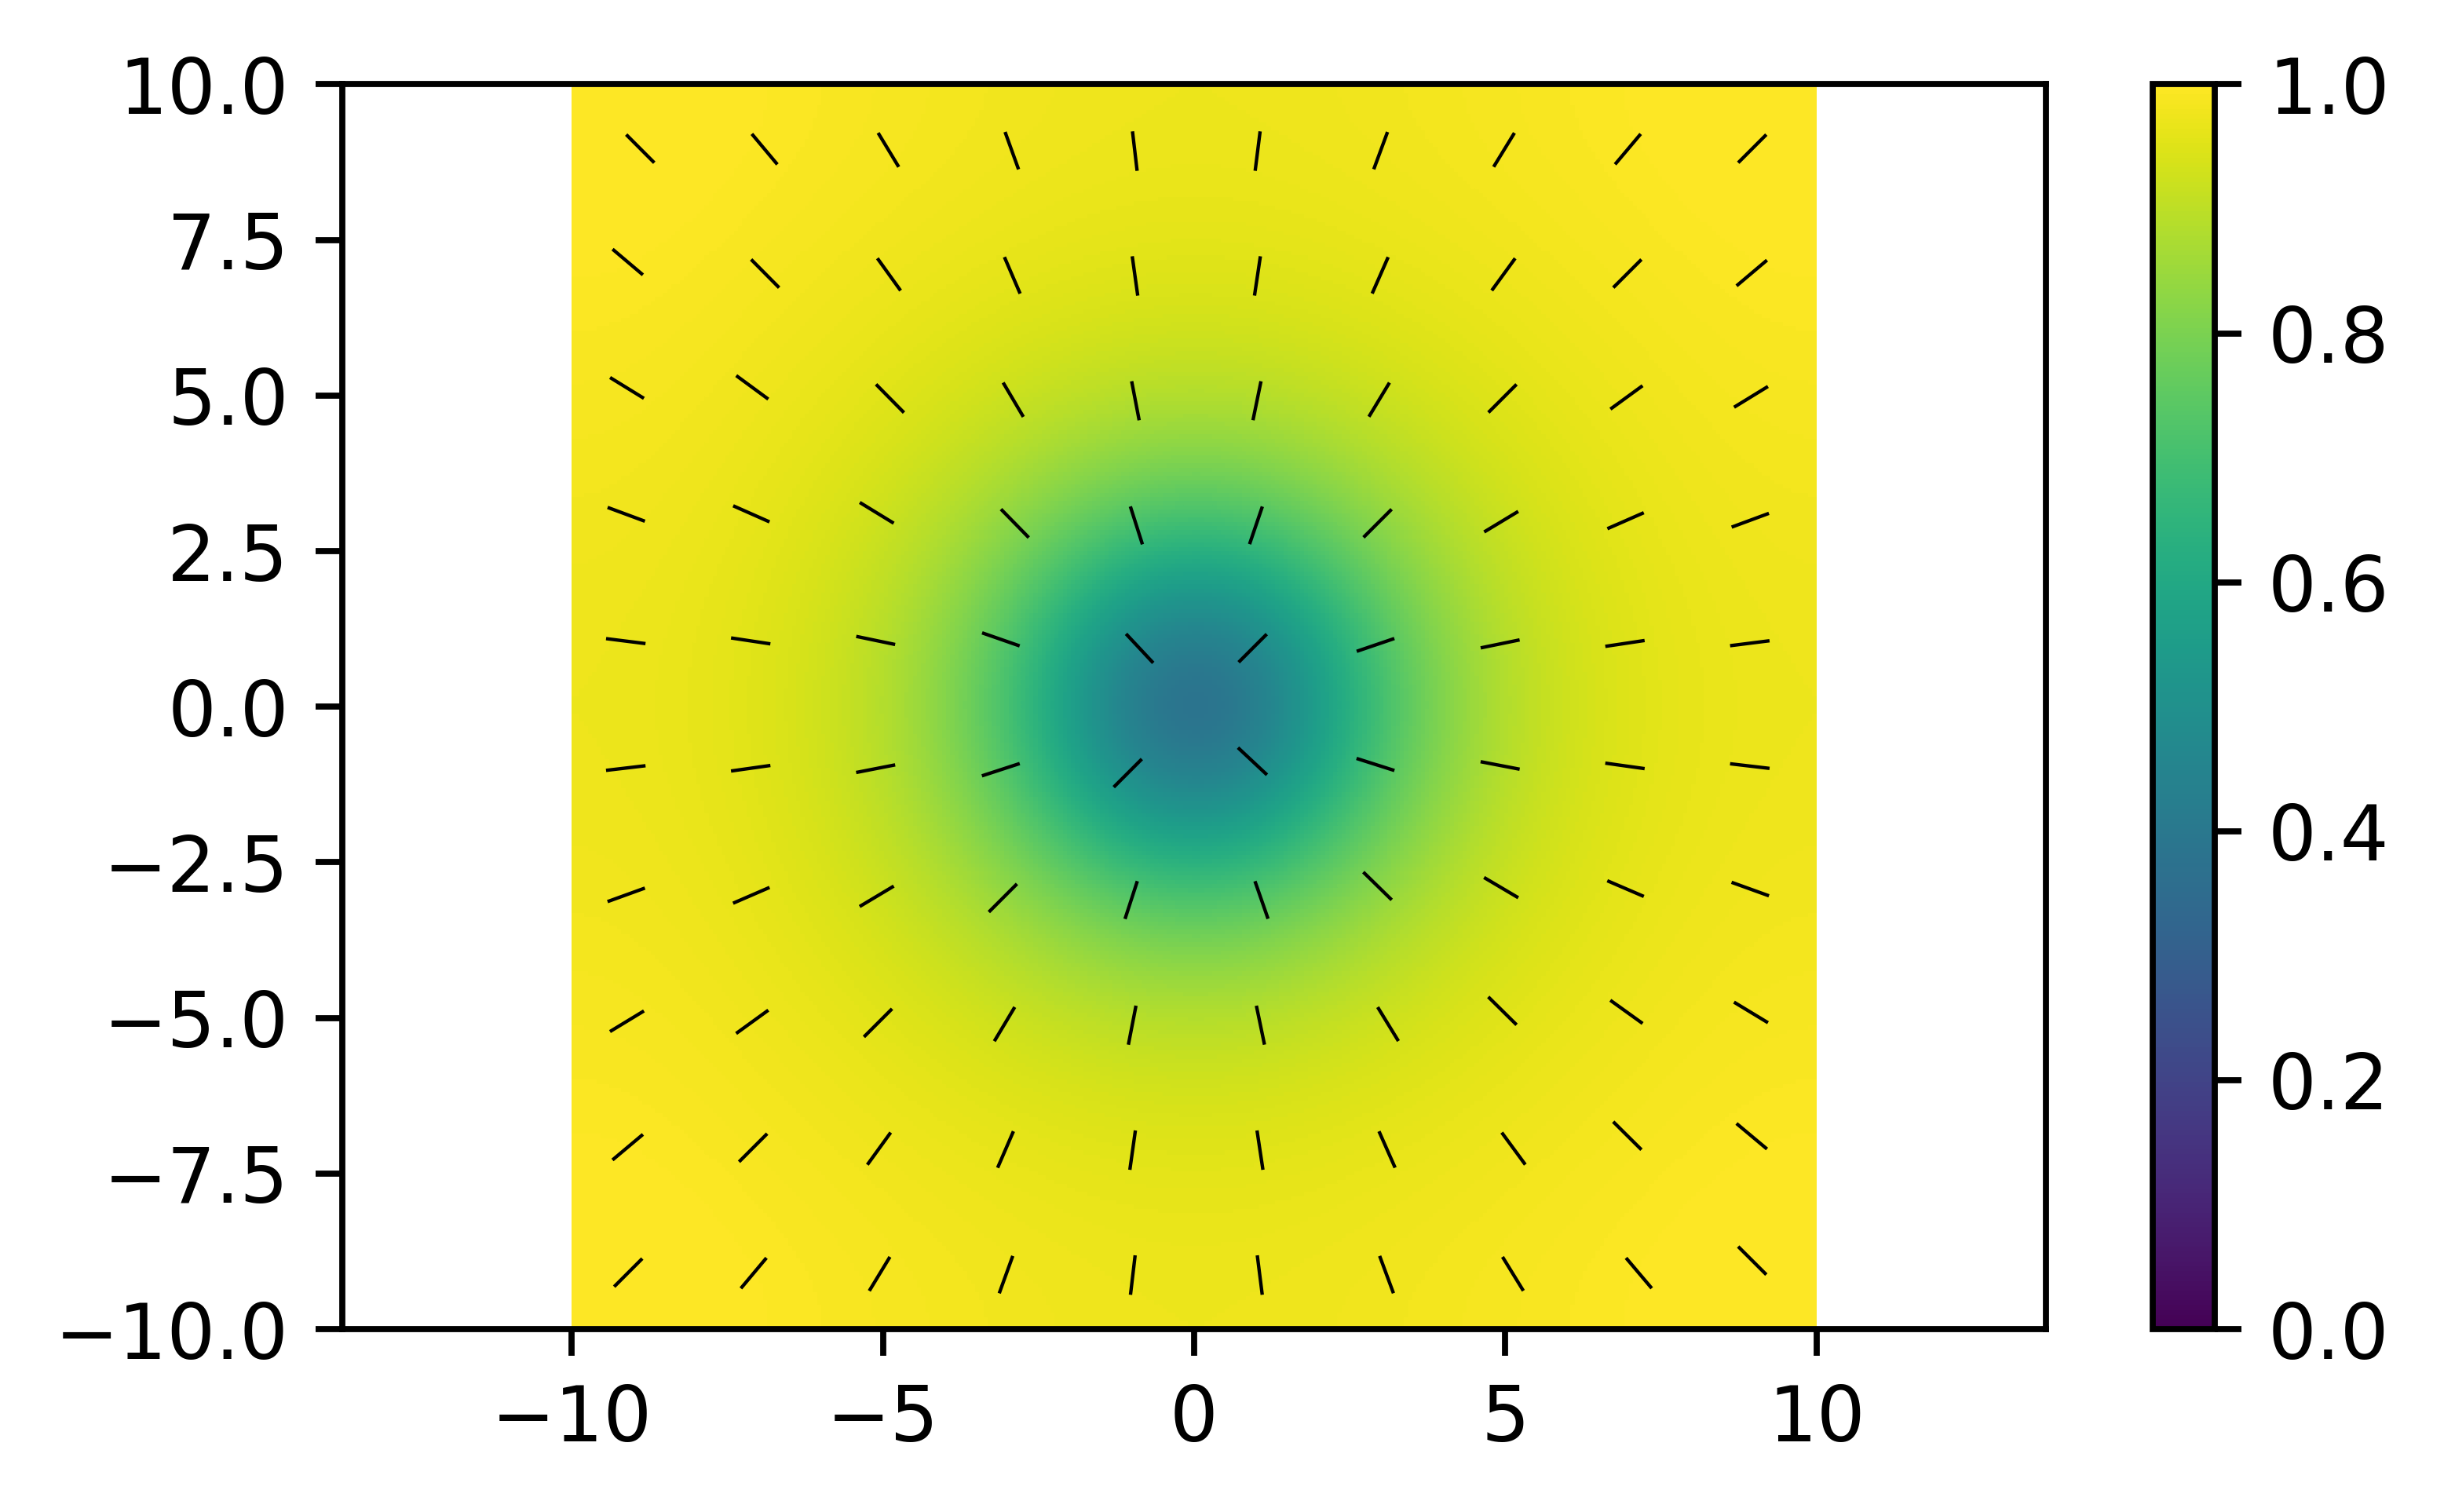

In [251]:
sparse_shape = (10, 10)
S_sparse_shape = (300, 300)
S_cutoff = 0.1

lambda_pm = lch.calcQEigenvals(eta_old, mu_old, nu_old)
U, V = lch.calcQEigenvecs(eta_old, mu_old, nu_old, lambda_pm, S_cutoff)

sparse_idx = lch.sparseIdx(Q[0, 0].shape, sparse_shape)
S_sparse_idx = lch.sparseIdx(Q[0, 0].shape, S_sparse_shape)

fig, ax = plt.subplots(figsize=(5, 3))
c = ax.pcolor(X[S_sparse_idx], Y[S_sparse_idx], (3/2)*lambda_pm[S_sparse_idx], vmin=0, vmax=1)
q = ax.quiver(X[sparse_idx], Y[sparse_idx], U[sparse_idx], V[sparse_idx],
              headwidth=0, pivot='middle', headaxislength=5, scale=30, width=0.002)
ax.quiverkey(q, X=0.3, Y=1.1, U=10,
             label='Quiver key, length = 10', labelpos='E')
ax.axis('equal')
fig.colorbar(c, ax=ax)

### To figure out what's going on here, we need to find where the plot peaks. First we find the exact index for the maximum and then we take a slice at y being the y-value of that index.

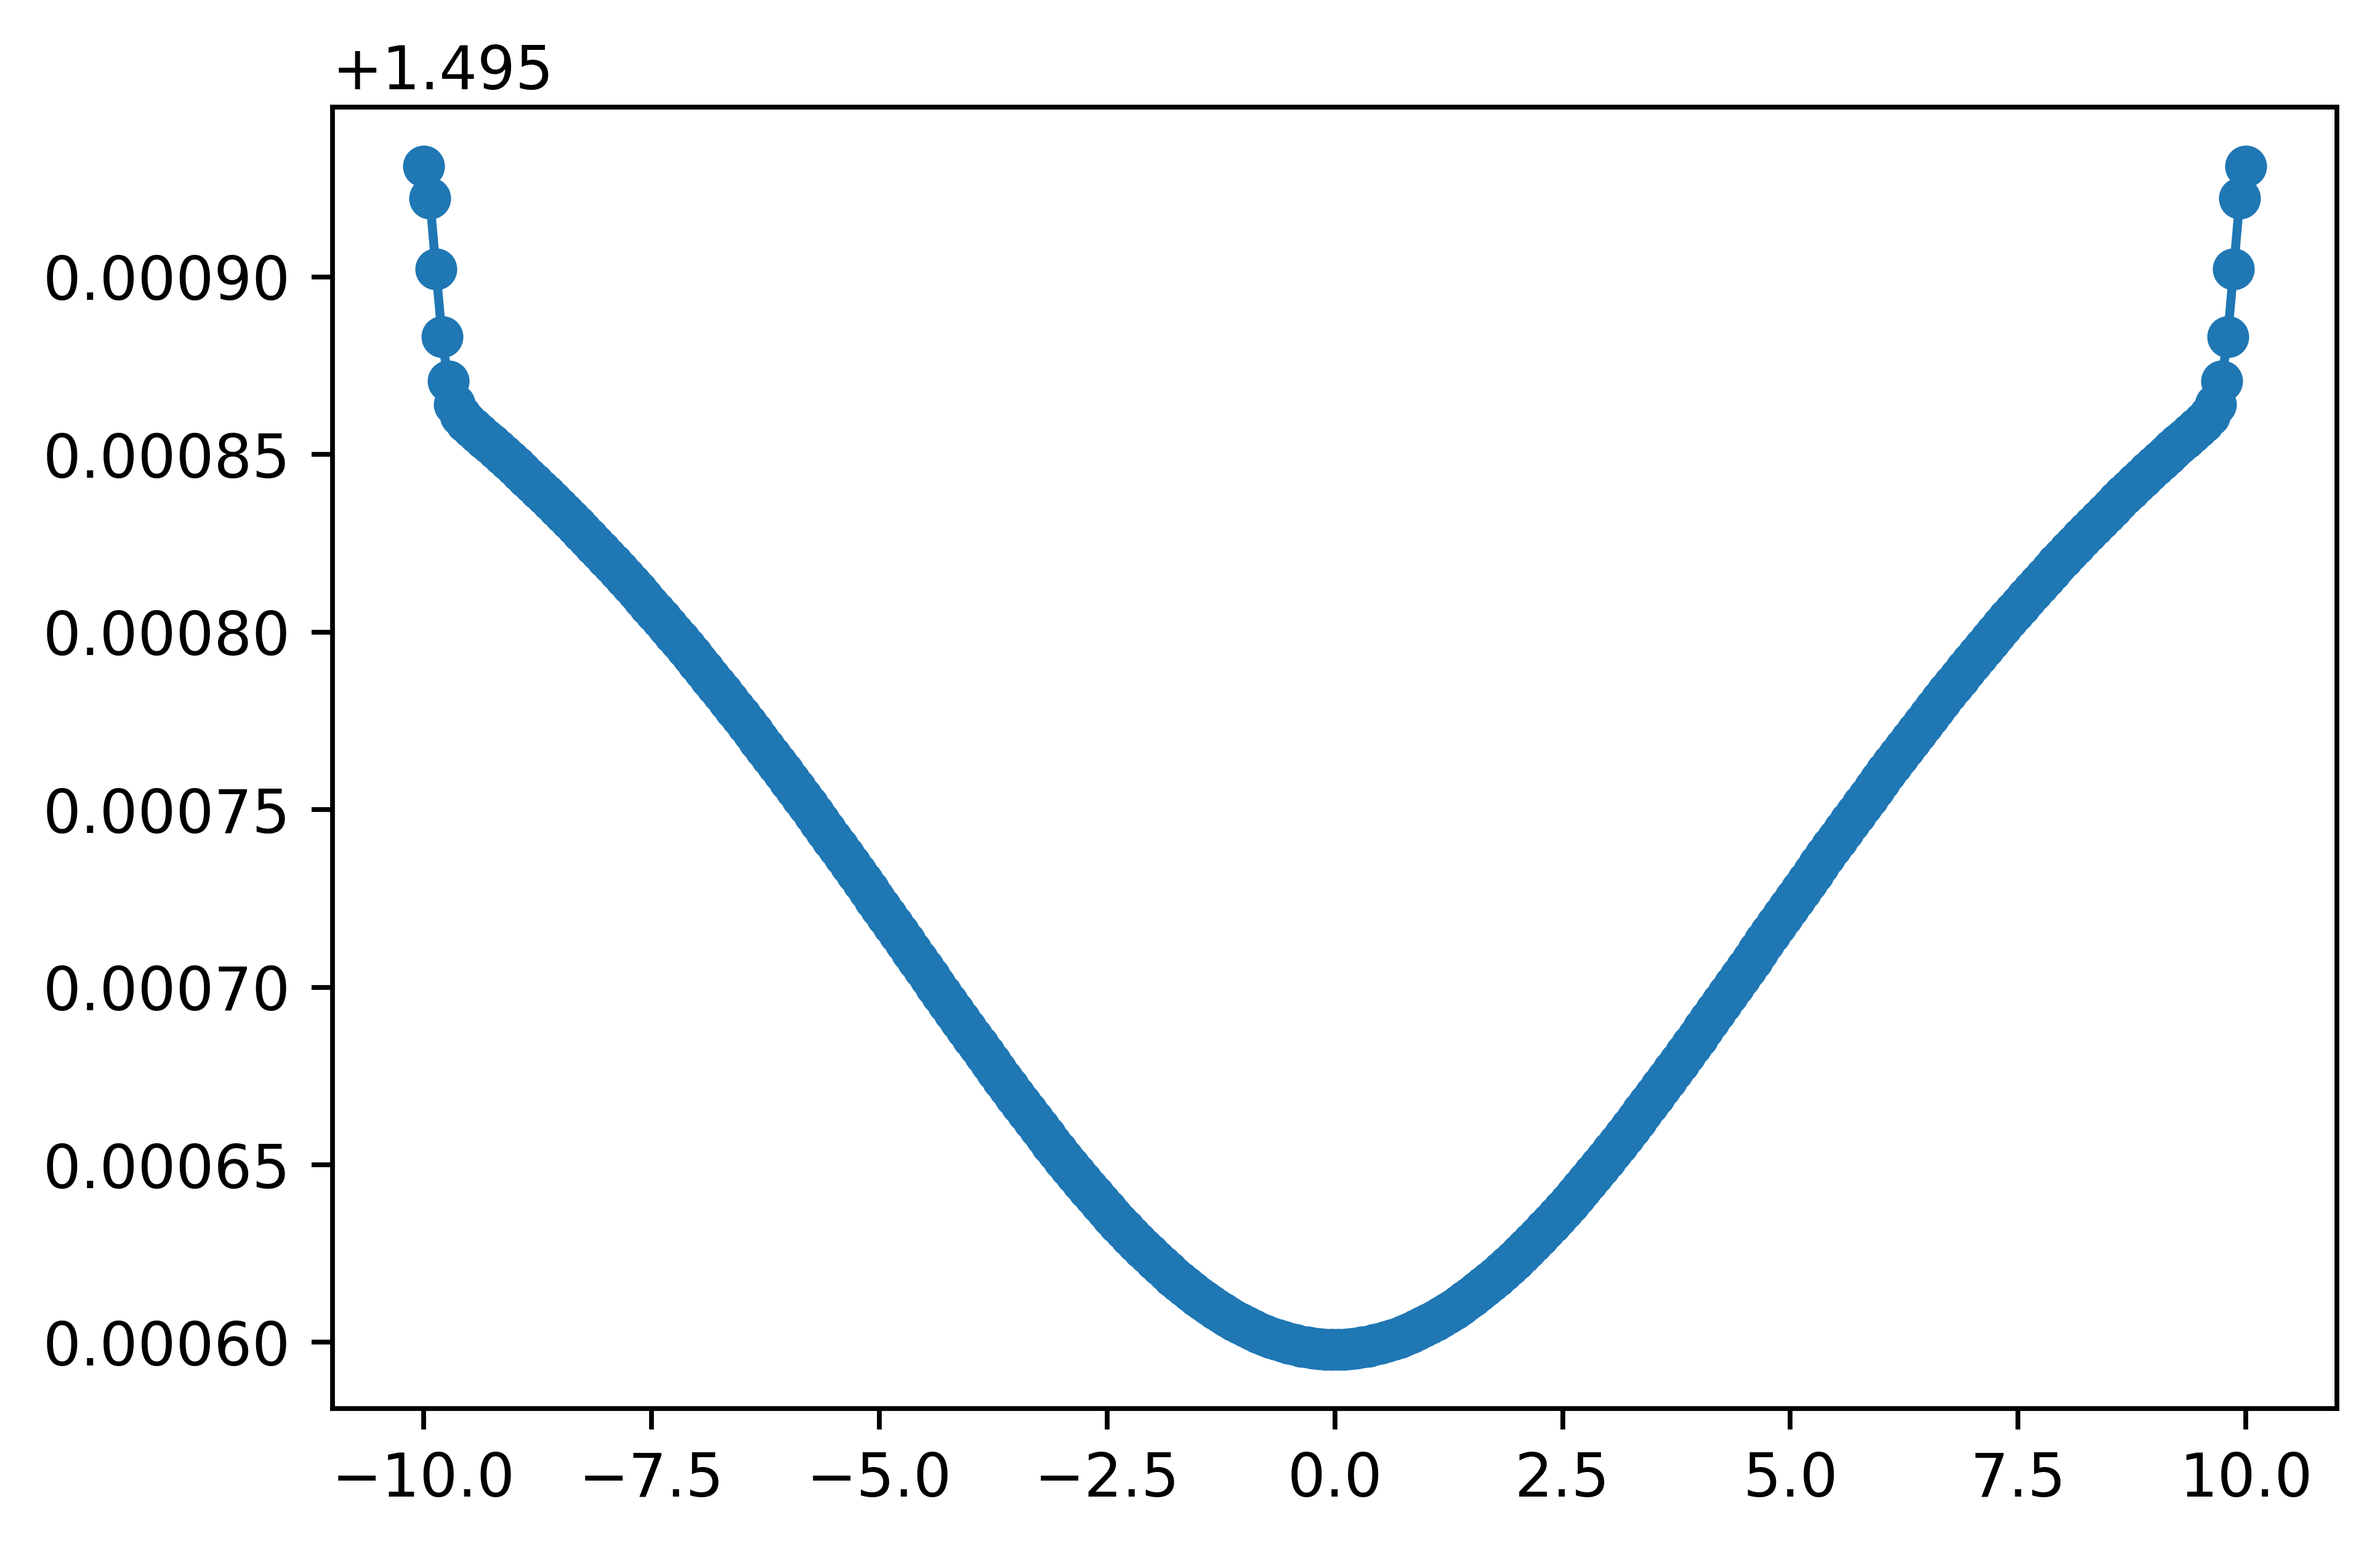

In [225]:
idx = np.unravel_index(np.argmax(lambda_pm), lambda_pm.shape)

plt.plot(X[:, idx[1]], (3/2)*lambda_pm[:, idx[1]], marker='o')

### Looks like things blow up at the endpoints. Need to figure out why that is happening.

### Want to just look at a central cut

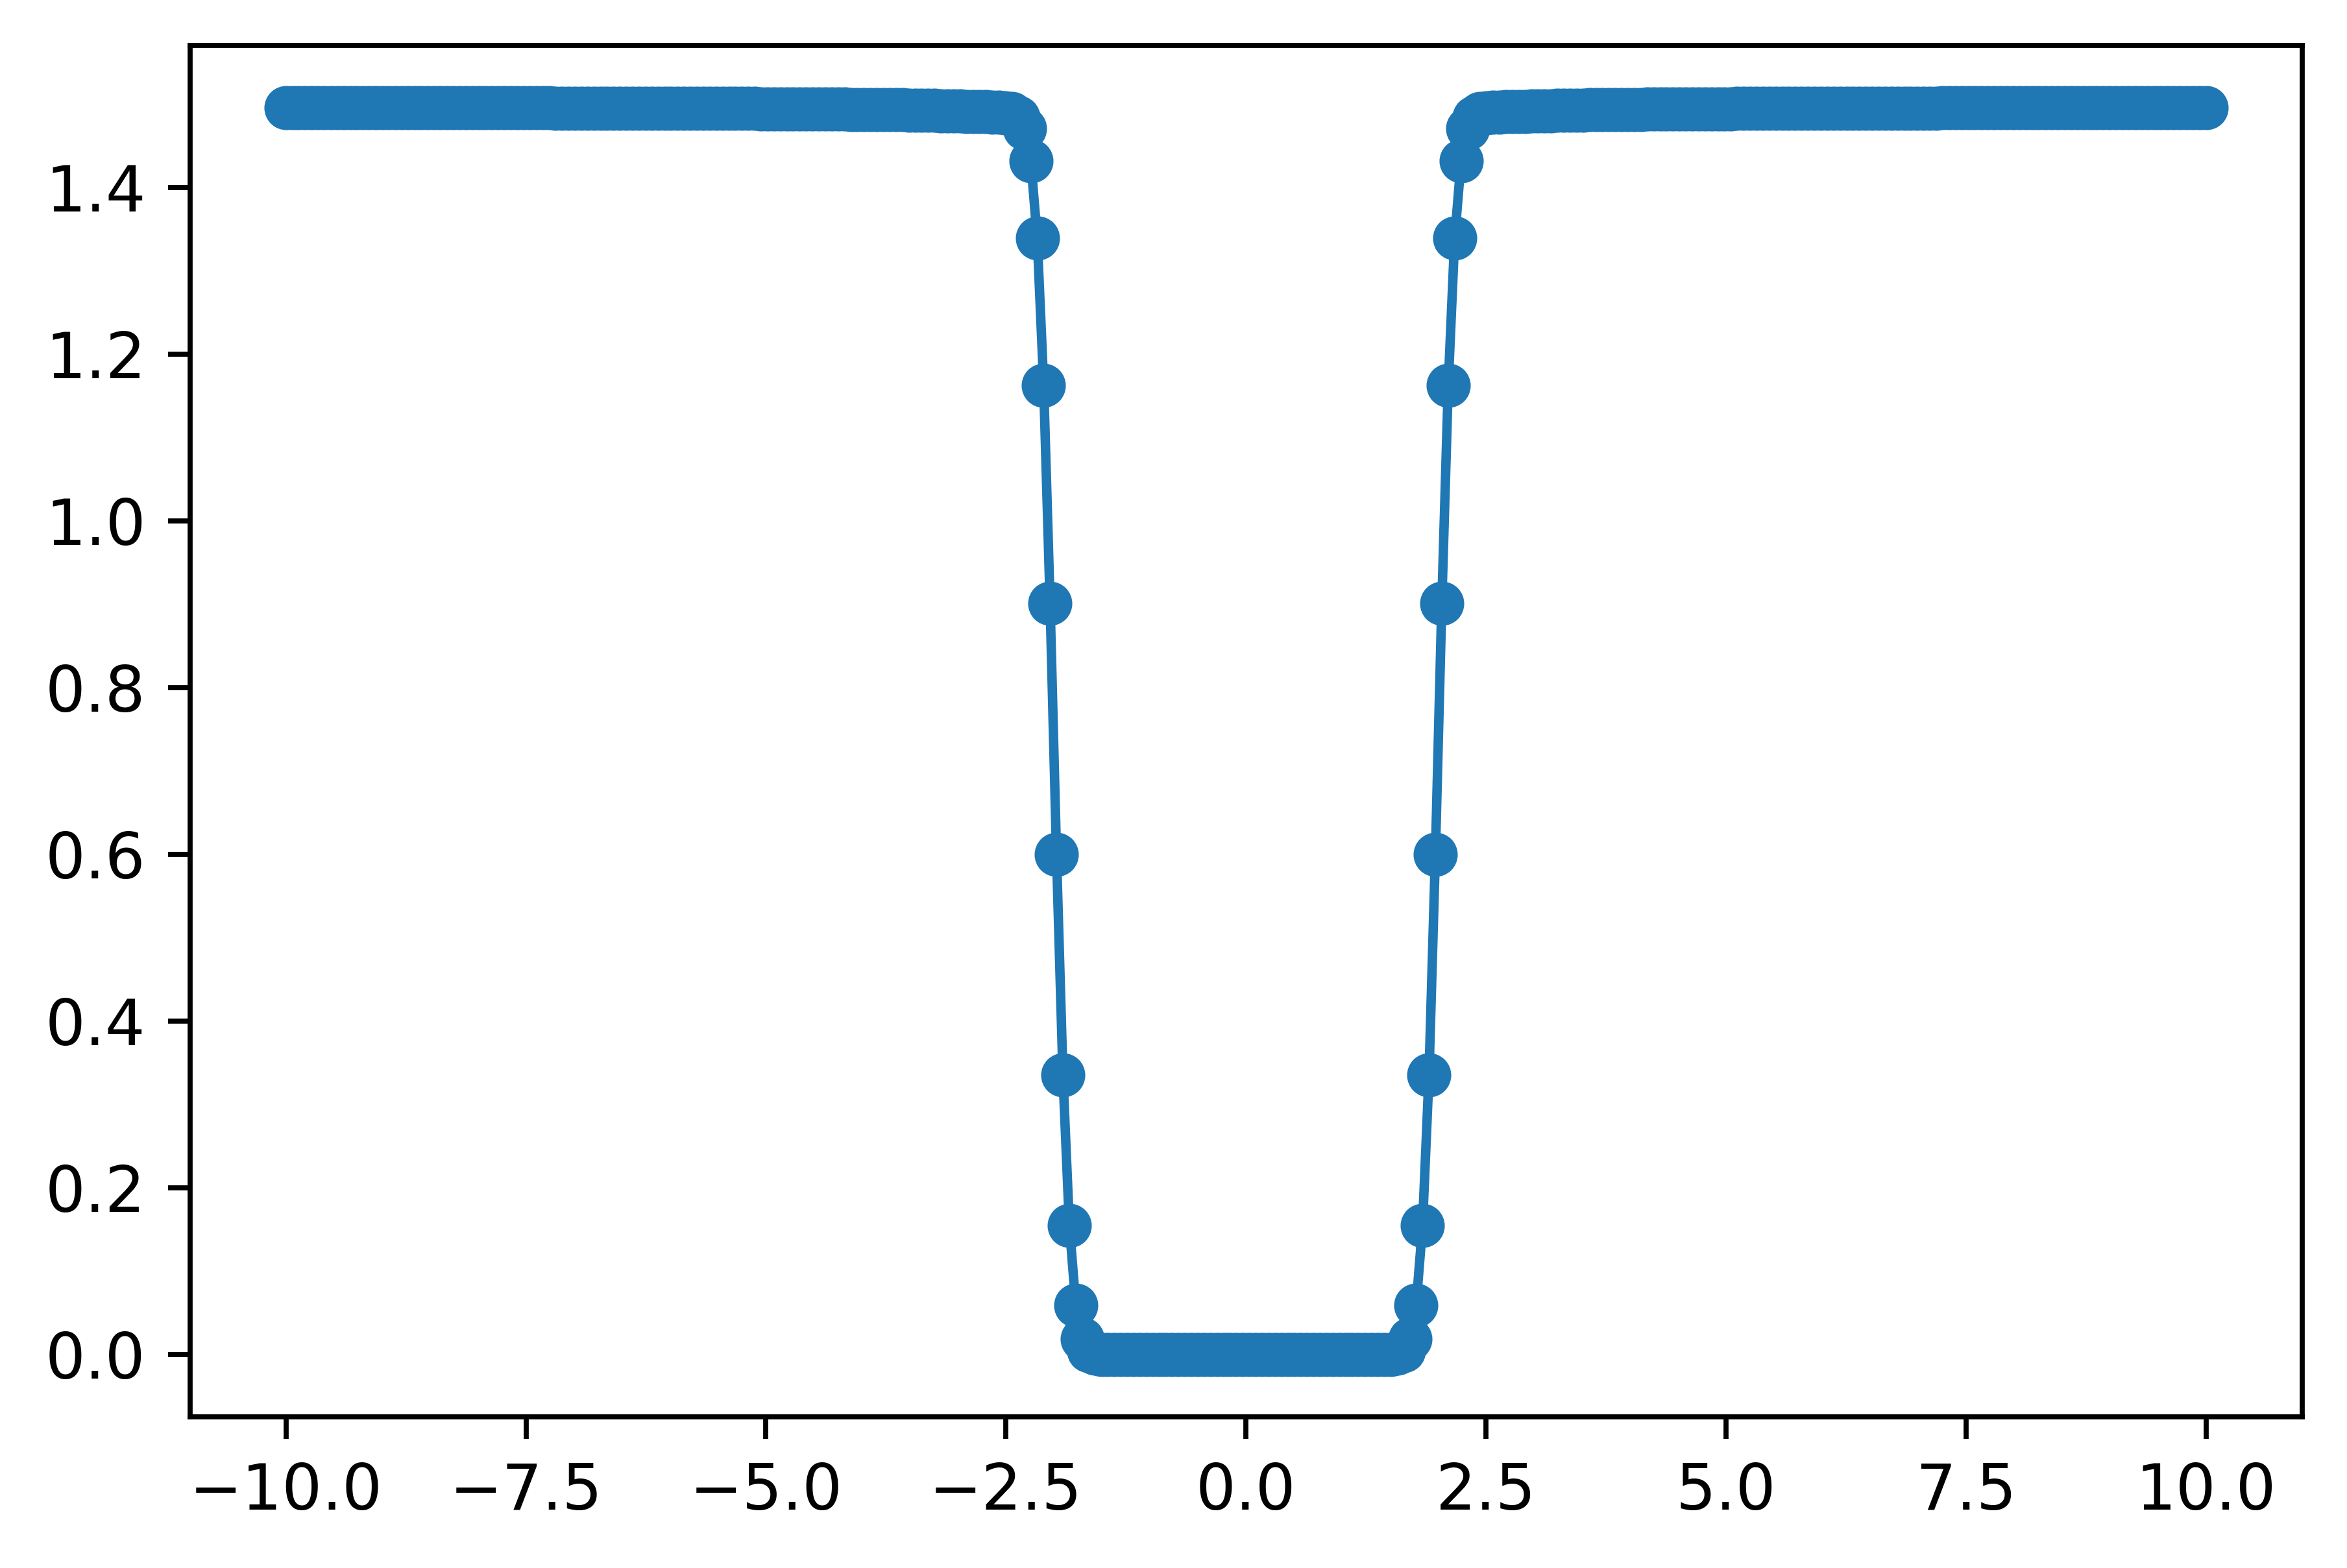

In [226]:
middle = np.floor(n/2).astype('int')

plt.plot(X[:, middle], (3/2)*lambda_pm[:, middle], marker='o')

### The central cut actually looks fine. What happens as we move away from the center?

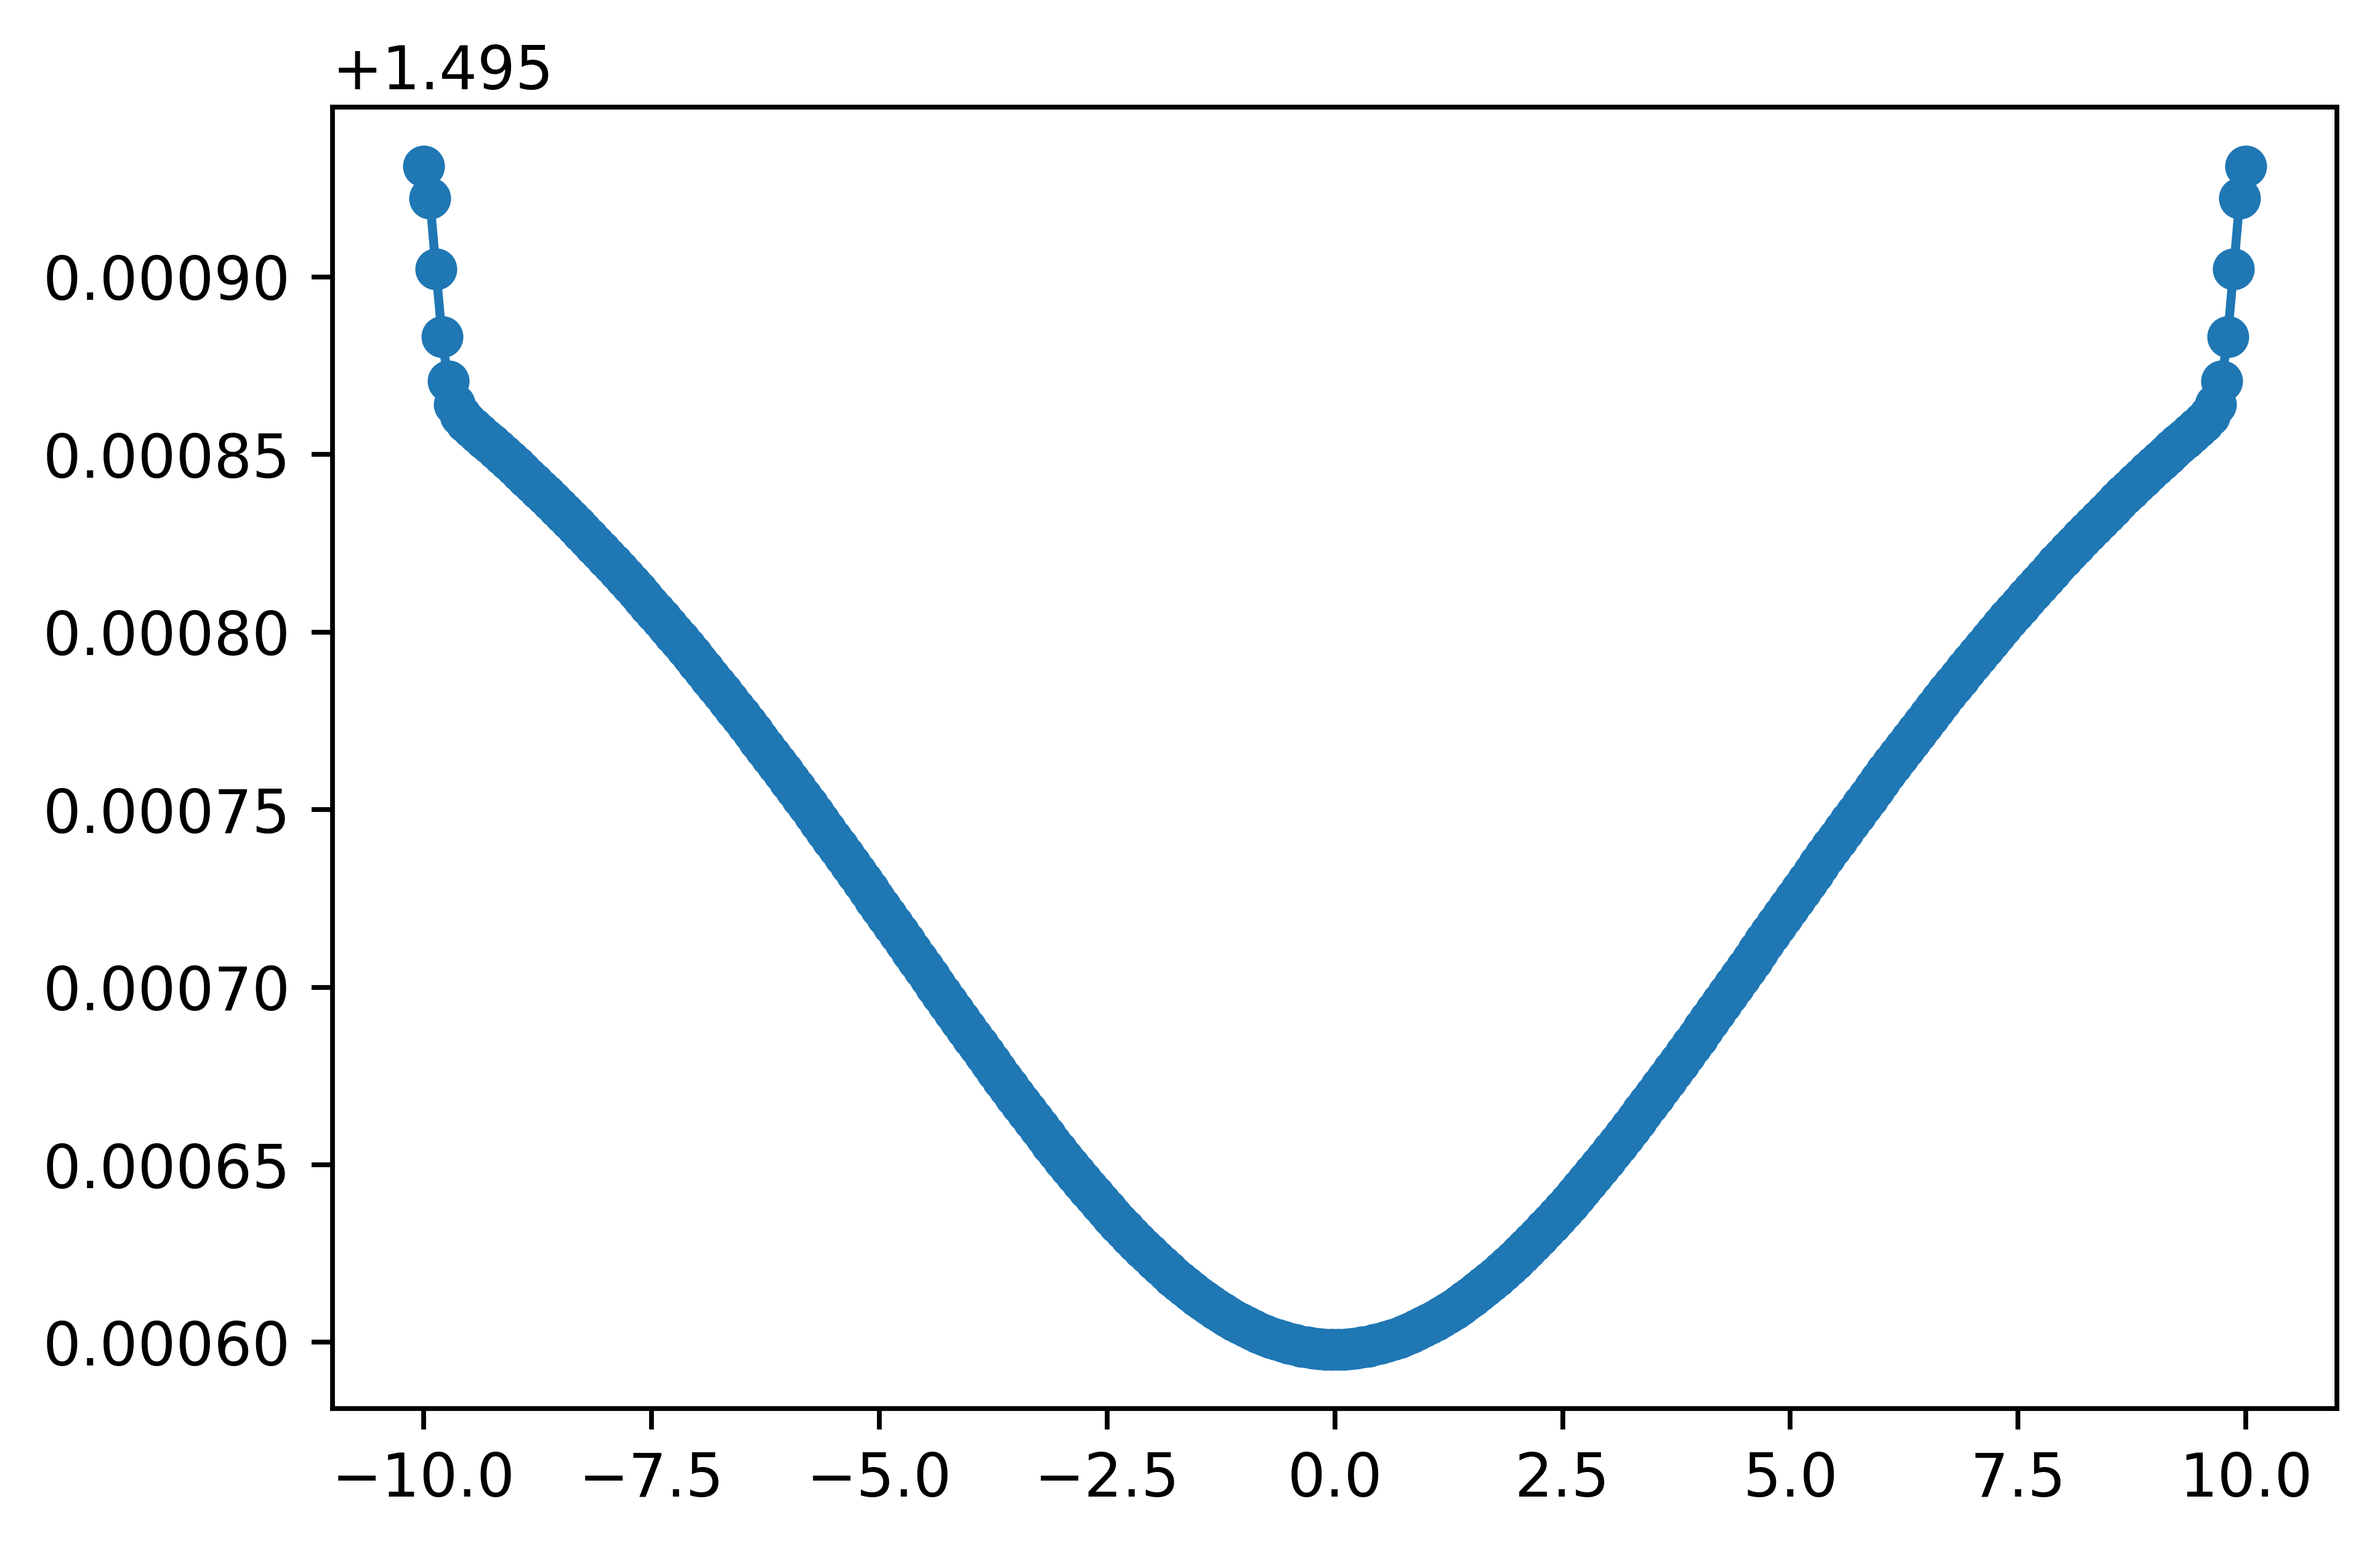

In [227]:
offset = 149

plt.plot(X[:, middle + offset], (3/2)*lambda_pm[:, middle + offset], marker='o')

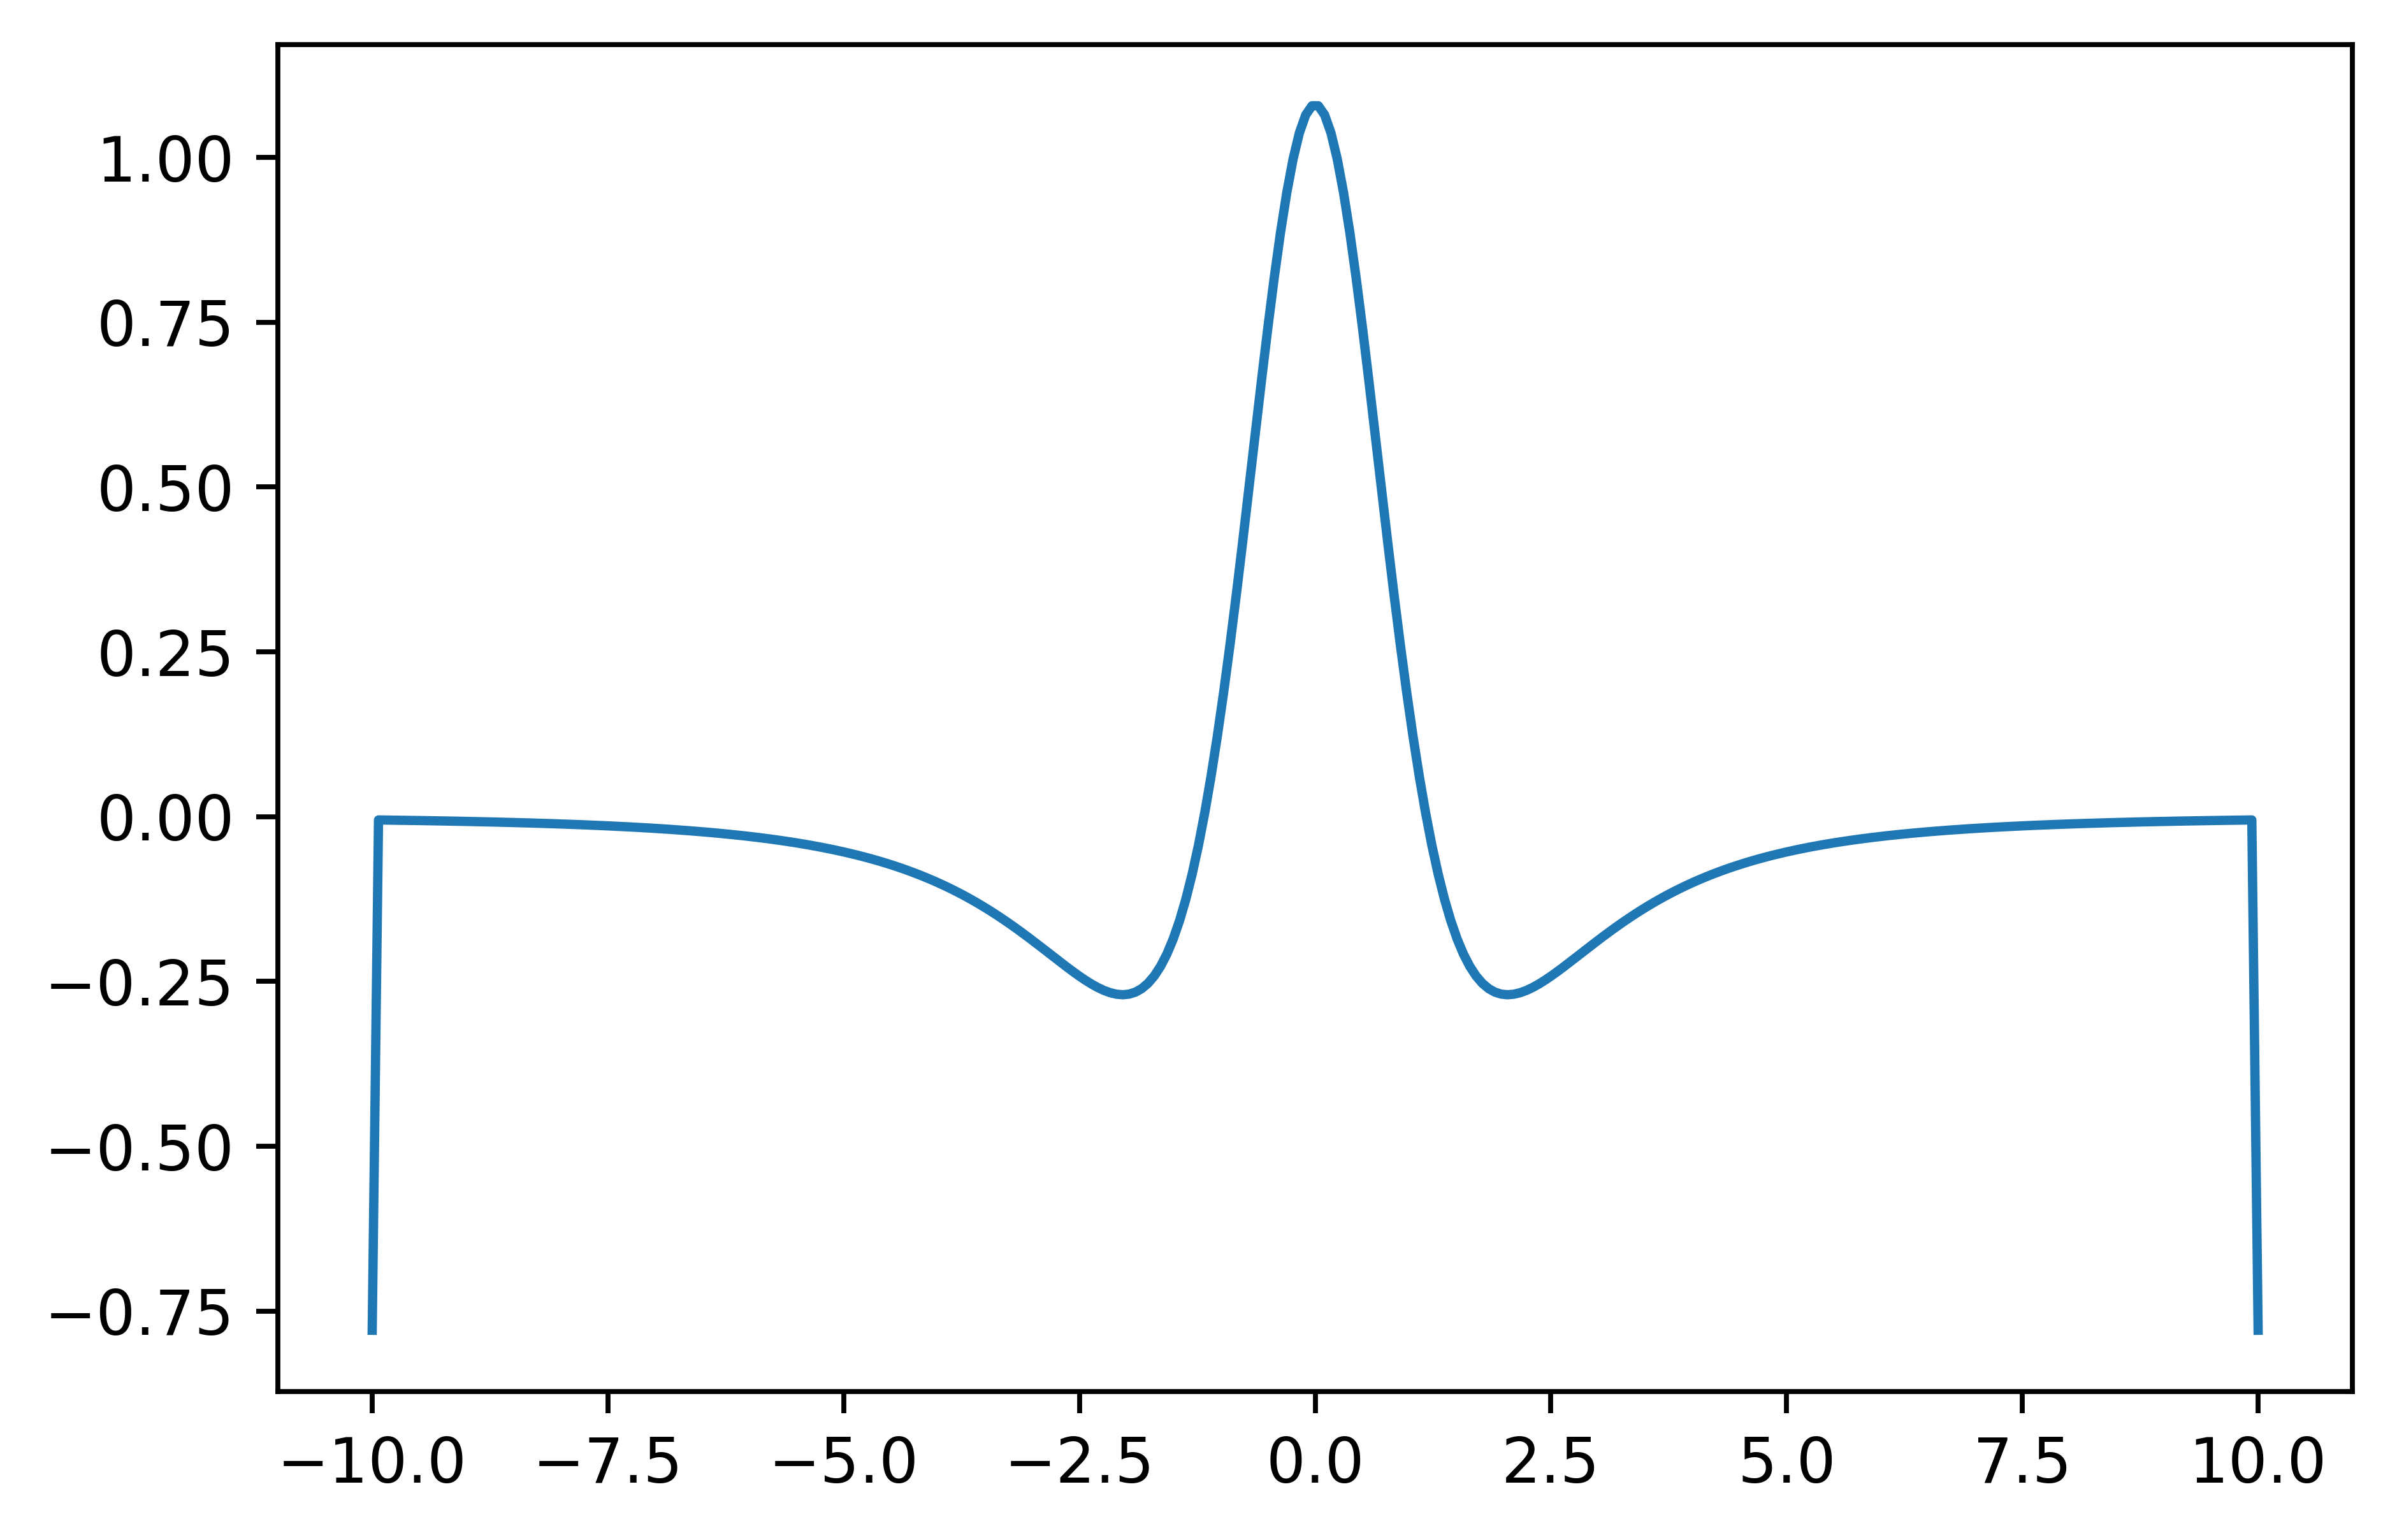

In [228]:
plt.plot(X[:, middle], fd.dx2(eta, dx)[:, middle + 30])

In [229]:
i = 1
(eta[i + 1, n - 10] - 2*eta[i, n - 10] + eta[i - 1, n - 10])/(dx**2)

-0.012624572386647251

In [230]:
i = 50
(8*eta[i + 1, n - 1] - eta[i + 2, n - 1] - 7*eta[i, n - 1])/(2*dx**2)

-6.456249425088202

In [231]:
i = 1
(eta[i + 1, n - 10] - eta[i - 1, n - 10])/(2*dx)**2

-0.844011672392375

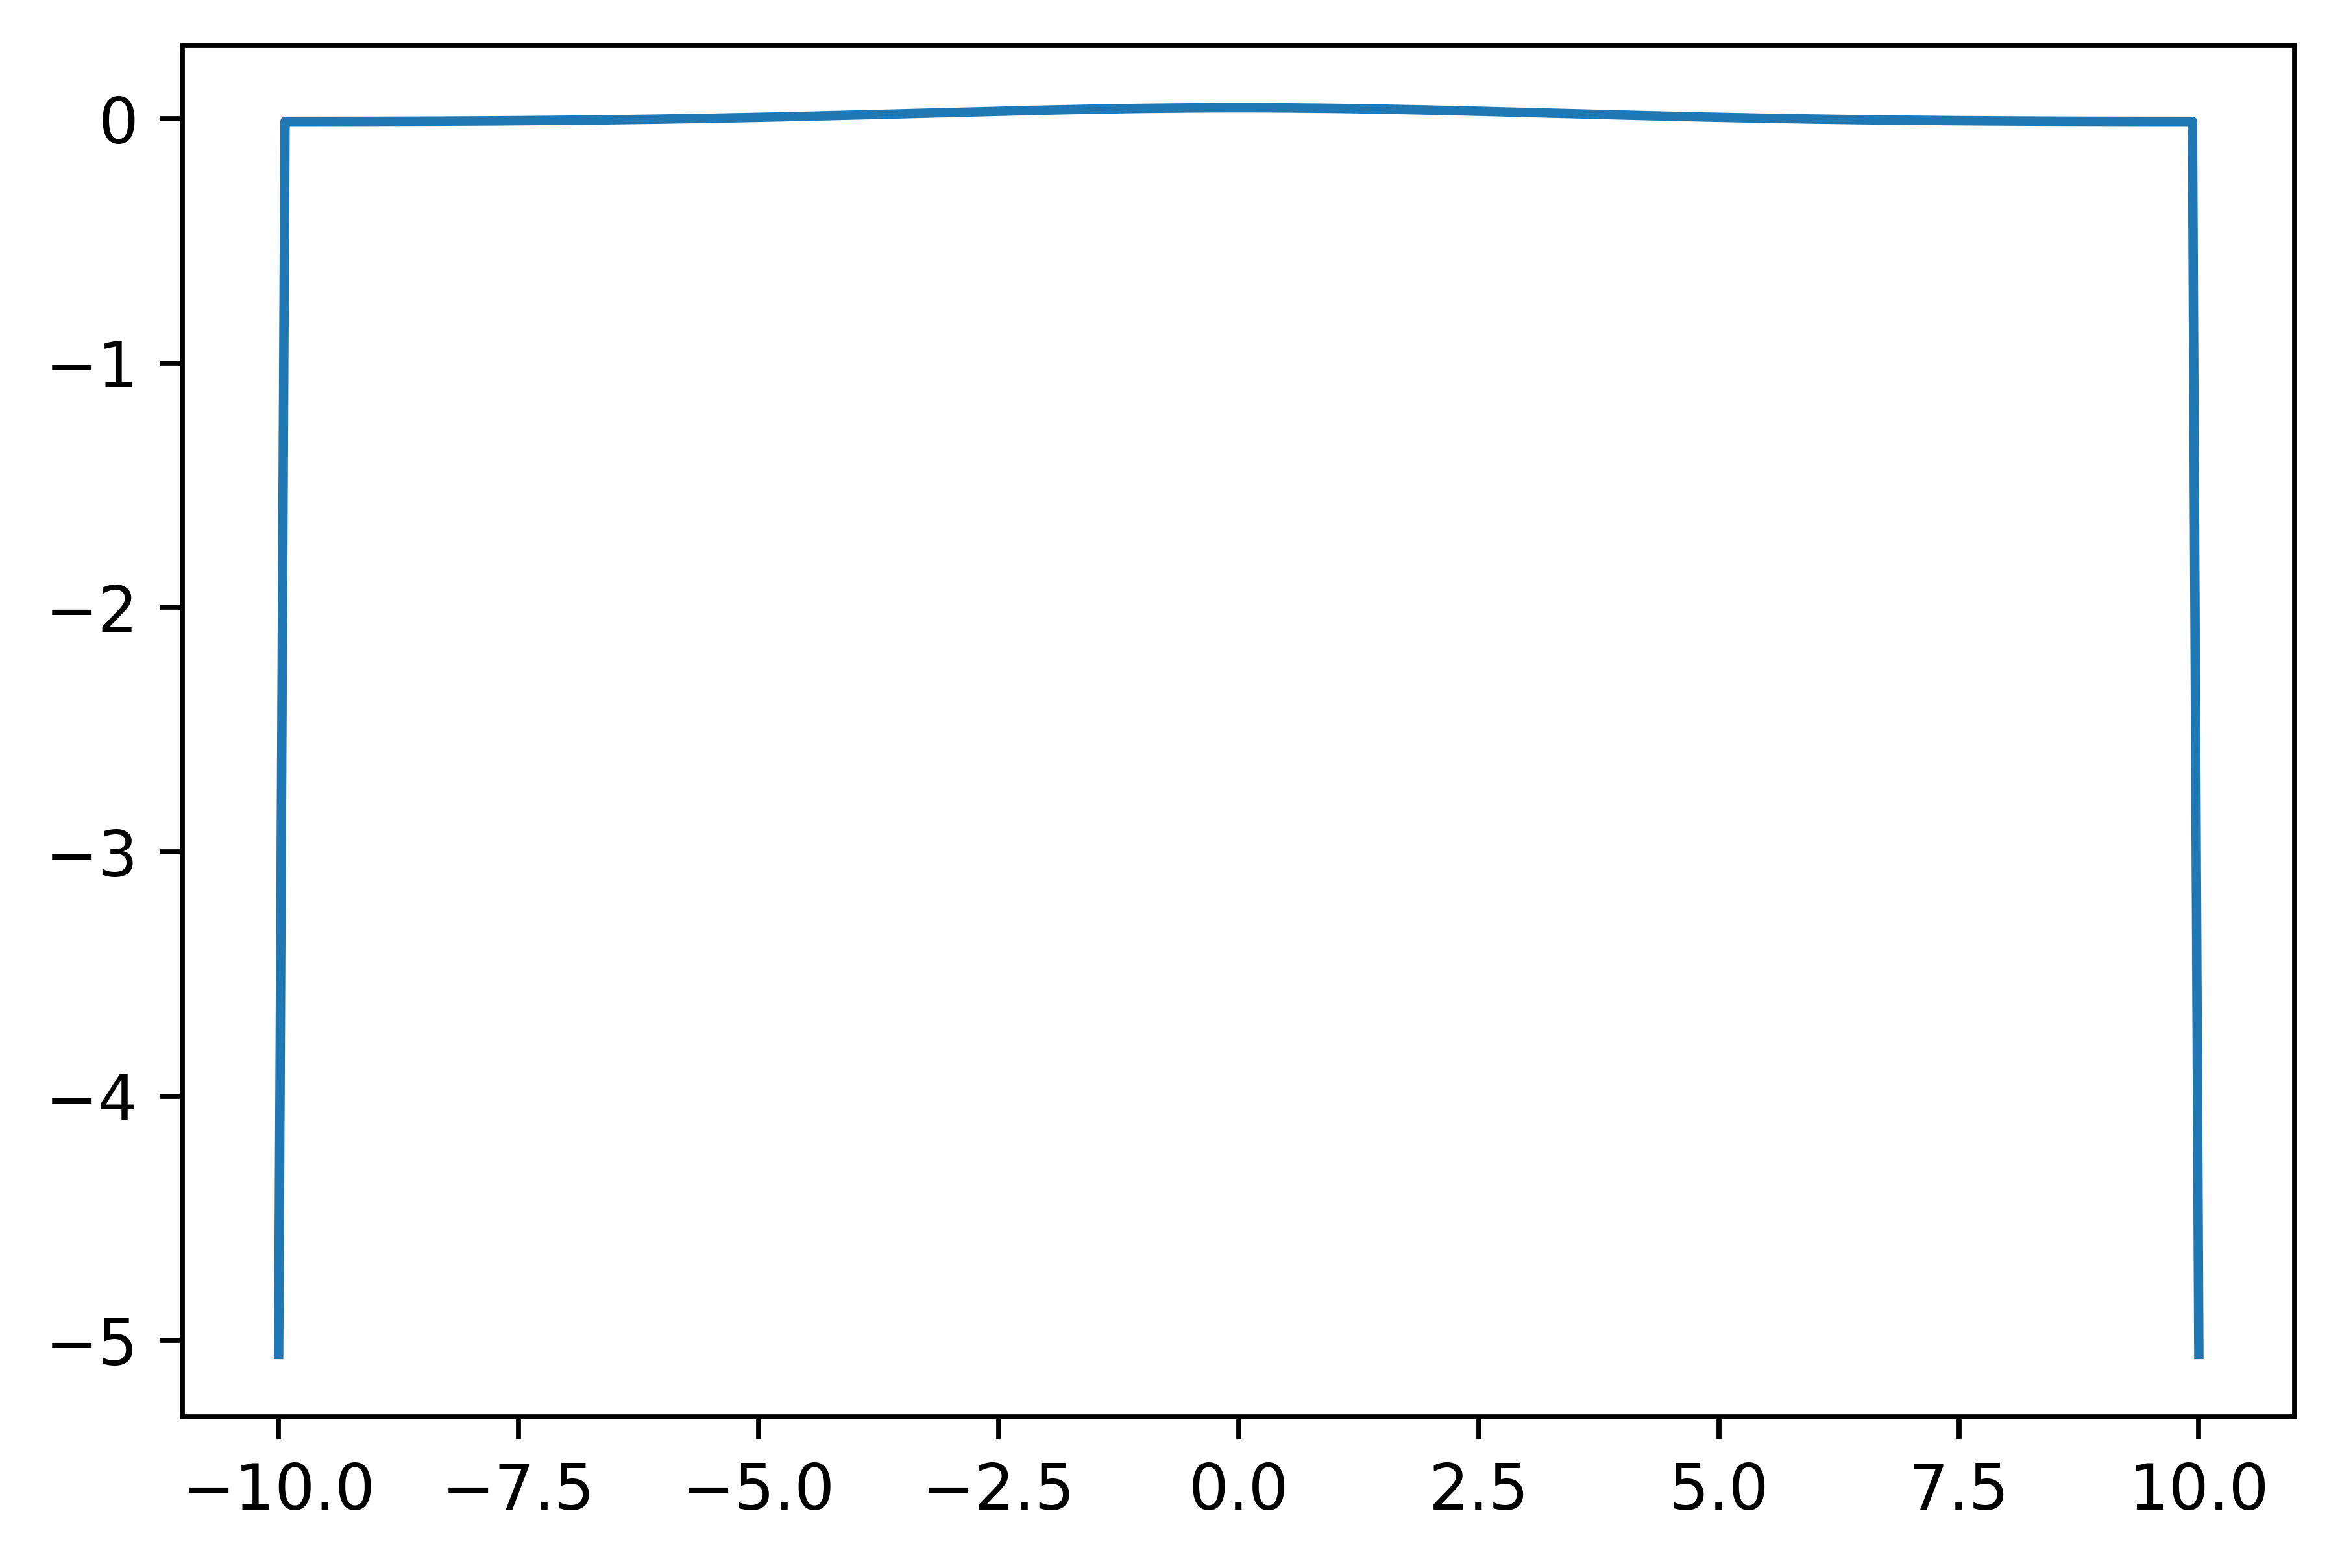

In [232]:
plt.plot(X[:, n - 1], fd.dx2(eta, dx)[:, n - 1])

In [114]:
fd.dx2(eta, dx)[1, 0]

-0.011248212848817352

### To do list:
1. Figure out whether I need to consider all of $Q_{ij}$ in order to effectively find $S$ and $P$ or just the upper right $2\times 2$.
2. Come up with different starting configurations (Cody's exponentially decaying tactoid, disclinations, etc.)
3. Figure out the difference between disclinations and tactoids.
4. Why don't tactoids collapse?
5. Figure out why there are still regions of high $S$ at the border.

### Observations
1. Depending on how many points of $S$ I sample for the colormap, the scale rises or falls -- I don't see the highest-valued colors on the actual plot, though. 
2. It seems like the number skyrockets only after many iterations.
3. Might it have to do with the sudden drop into the tactoid zone?
4. Could I fix this with a more reasonable tactoid decay?
5. I wonder if changing it to a sigmoid would make any difference.
6. Does the blowing up have to do with the LdG energy?

### Responses to these observations
1. I think it has nothing to do with the tactoid.
2. Rather, it is caused by the explicit finite difference method at the boundary (with Neumann boundary conditions) being possibly unstable.
3. Not really sure what to do to fix this, but I would like to document the behavior as much as possible. 
4. I think it might just be based on how small the timestep is -- should be stable, but I guess it's not.